In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# Federated learning hyperparameters
num_epochs, learning_rate = 5, 0.001
batch_sizes, communication_rounds = [64, 128], 100

In [4]:
# Define a deep learning model (CNN)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Modify the architecture based on your requirements
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [5]:
# Dataset preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Assuming you have the FEMNIST dataset downloaded and split for each client
# Replace 'path_to_client_data' with the actual path to the client data
client_dataset = torchvision.datasets.FashionMNIST(root='path_to_client_data', train=True, download=True, transform=transform)

# Split the client dataset into train and validation sets
train_size = int(0.8 * len(client_dataset))
val_size = len(client_dataset) - train_size
client_train_set, client_val_set = random_split(client_dataset, [train_size, val_size])

# DataLoader for training and validation
train_loaders = [DataLoader(client_train_set, batch_size=batch_size, shuffle=True, num_workers=4) for batch_size in batch_sizes]
val_loader = DataLoader(client_val_set, batch_size=batch_sizes[0], shuffle=False, num_workers=4)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting path_to_client_data\FashionMNIST\raw\train-images-idx3-ubyte.gz to path_to_client_data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting path_to_client_data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to path_to_client_data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting path_to_client_data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to path_to_client_data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting path_to_client_data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to path_to_client_data\FashionMNIST\raw



In [10]:
# Function to train the model for a given federated learning algorithm
def train_federated_learning(model, train_loader, algorithm_name):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [9]:
def train_federated_learningAdj(model, train_loader, algorithm_name, times):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize the convolutional layer outside the loop
    in_channels = train_loader.dataset[0][0].shape[0]  # Number of input channels
    out_channels = max(1, in_channels - times) 
    conv_reduce_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name}'):
            images, labels = images.to(device), labels.to(device)
            
            # Apply the convolutional layer to input images
            data = conv_reduce_channels(images)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Define the evaluation function as provided
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [11]:
# Train & Evaluate FedAvg
fedavg_model = CNNModel().to(device)
fedavg_performance = train_federated_learning(fedavg_model, train_loaders[0], 'FedAvg')
fedavg_model100 = CNNModel().to(device)
fedavg_performance100 = train_federated_learningAdj(fedavg_model100, train_loaders[0], 'FedAvgAdj100', 100)
fedavg_model200 = CNNModel().to(device)
fedavg_performance200 = train_federated_learningAdj(fedavg_model200, train_loaders[0], 'FedAvgAdj200', 200)
fedavg_model300 = CNNModel().to(device)
fedavg_performance300 = train_federated_learningAdj(fedavg_model300, train_loaders[0], 'FedAvgAdj300', 300)

Epoch 1/5 - FedAvg: 100%|██████████| 750/750 [01:20<00:00,  9.34it/s]


Epoch [1/5] - FedAvg, Loss: 0.4331
Epoch [1/5] - FedAvg, Validation Accuracy: 88.03%


Epoch 2/5 - FedAvg: 100%|██████████| 750/750 [01:48<00:00,  6.92it/s]


Epoch [2/5] - FedAvg, Loss: 0.2743
Epoch [2/5] - FedAvg, Validation Accuracy: 90.72%


Epoch 3/5 - FedAvg: 100%|██████████| 750/750 [01:23<00:00,  8.96it/s]


Epoch [3/5] - FedAvg, Loss: 0.2223
Epoch [3/5] - FedAvg, Validation Accuracy: 90.65%


Epoch 4/5 - FedAvg: 100%|██████████| 750/750 [01:25<00:00,  8.80it/s]


Epoch [4/5] - FedAvg, Loss: 0.1867
Epoch [4/5] - FedAvg, Validation Accuracy: 91.62%


Epoch 5/5 - FedAvg: 100%|██████████| 750/750 [02:36<00:00,  4.78it/s]


Epoch [5/5] - FedAvg, Loss: 0.1559
Epoch [5/5] - FedAvg, Validation Accuracy: 91.83%


Epoch 1/5 - FedAvgAdj100: 100%|██████████| 750/750 [02:14<00:00,  5.57it/s]


Epoch [1/5] - FedAvgAdj100, Loss: 0.5042
Epoch [1/5] - FedAvgAdj100, Validation Accuracy: 84.23%


Epoch 2/5 - FedAvgAdj100: 100%|██████████| 750/750 [03:51<00:00,  3.24it/s]


Epoch [2/5] - FedAvgAdj100, Loss: 0.3146
Epoch [2/5] - FedAvgAdj100, Validation Accuracy: 87.25%


Epoch 3/5 - FedAvgAdj100: 100%|██████████| 750/750 [09:11<00:00,  1.36it/s]  


Epoch [3/5] - FedAvgAdj100, Loss: 0.2678
Epoch [3/5] - FedAvgAdj100, Validation Accuracy: 88.21%


Epoch 4/5 - FedAvgAdj100: 100%|██████████| 750/750 [07:49<00:00,  1.60it/s]


Epoch [4/5] - FedAvgAdj100, Loss: 0.2354
Epoch [4/5] - FedAvgAdj100, Validation Accuracy: 88.22%


Epoch 5/5 - FedAvgAdj100: 100%|██████████| 750/750 [08:03<00:00,  1.55it/s]


Epoch [5/5] - FedAvgAdj100, Loss: 0.2088
Epoch [5/5] - FedAvgAdj100, Validation Accuracy: 88.08%


Epoch 1/5 - FedAvgAdj200: 100%|██████████| 750/750 [08:03<00:00,  1.55it/s]


Epoch [1/5] - FedAvgAdj200, Loss: 0.4525
Epoch [1/5] - FedAvgAdj200, Validation Accuracy: 15.66%


Epoch 2/5 - FedAvgAdj200: 100%|██████████| 750/750 [06:51<00:00,  1.82it/s]


Epoch [2/5] - FedAvgAdj200, Loss: 0.2825
Epoch [2/5] - FedAvgAdj200, Validation Accuracy: 18.10%


Epoch 3/5 - FedAvgAdj200: 100%|██████████| 750/750 [07:56<00:00,  1.57it/s]


Epoch [3/5] - FedAvgAdj200, Loss: 0.2284
Epoch [3/5] - FedAvgAdj200, Validation Accuracy: 15.82%


Epoch 4/5 - FedAvgAdj200: 100%|██████████| 750/750 [04:59<00:00,  2.51it/s]


Epoch [4/5] - FedAvgAdj200, Loss: 0.1930
Epoch [4/5] - FedAvgAdj200, Validation Accuracy: 9.95%


Epoch 5/5 - FedAvgAdj200: 100%|██████████| 750/750 [06:43<00:00,  1.86it/s]


Epoch [5/5] - FedAvgAdj200, Loss: 0.1637
Epoch [5/5] - FedAvgAdj200, Validation Accuracy: 9.53%


Epoch 1/5 - FedAvgAdj300: 100%|██████████| 750/750 [02:09<00:00,  5.77it/s]


Epoch [1/5] - FedAvgAdj300, Loss: 0.4674
Epoch [1/5] - FedAvgAdj300, Validation Accuracy: 13.29%


Epoch 2/5 - FedAvgAdj300: 100%|██████████| 750/750 [04:59<00:00,  2.50it/s]


Epoch [2/5] - FedAvgAdj300, Loss: 0.2947
Epoch [2/5] - FedAvgAdj300, Validation Accuracy: 23.19%


Epoch 3/5 - FedAvgAdj300: 100%|██████████| 750/750 [05:03<00:00,  2.47it/s]


Epoch [3/5] - FedAvgAdj300, Loss: 0.2429
Epoch [3/5] - FedAvgAdj300, Validation Accuracy: 25.06%


Epoch 4/5 - FedAvgAdj300: 100%|██████████| 750/750 [02:35<00:00,  4.82it/s]


Epoch [4/5] - FedAvgAdj300, Loss: 0.2104
Epoch [4/5] - FedAvgAdj300, Validation Accuracy: 20.37%


Epoch 5/5 - FedAvgAdj300: 100%|██████████| 750/750 [09:22<00:00,  1.33it/s] 


Epoch [5/5] - FedAvgAdj300, Loss: 0.1808
Epoch [5/5] - FedAvgAdj300, Validation Accuracy: 17.38%


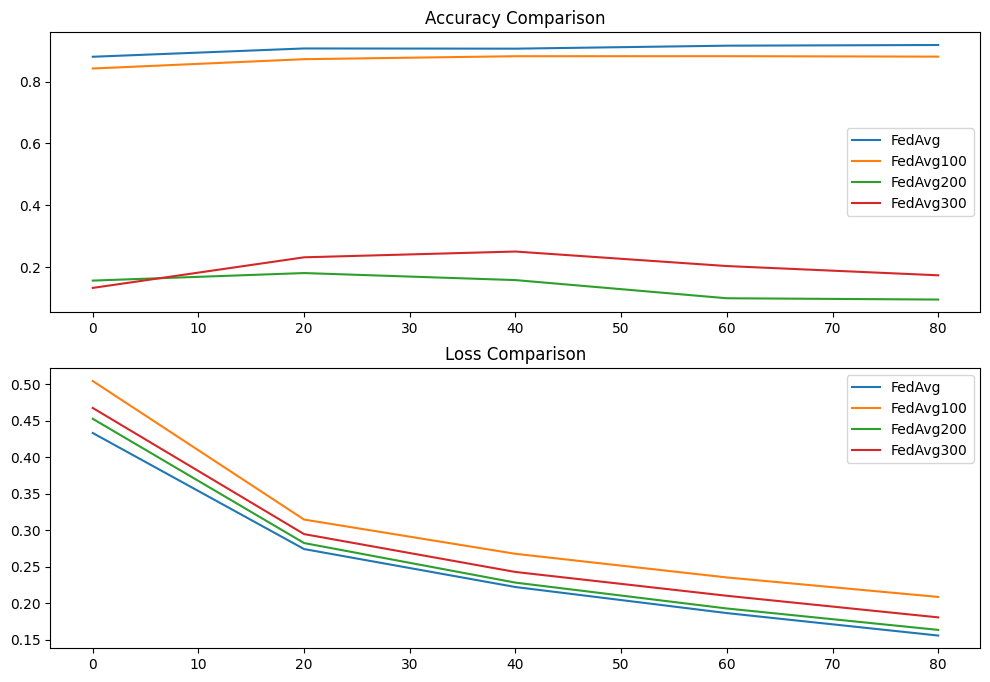

In [14]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance['accuracy'], label='FedAvg')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance100['accuracy'], label='FedAvg100')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance200['accuracy'], label='FedAvg200')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance300['accuracy'], label='FedAvg300')

# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance['loss'], label='FedAvg')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance100['loss'], label='FedAvg100')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance200['loss'], label='FedAvg200')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance300['loss'], label='FedAvg300')

plt.show()

In [16]:
# Train & Evaluate FedProx
fedprox_model = CNNModel().to(device)
fedprox_performance = train_federated_learning(fedprox_model, train_loaders[0], 'FedProx')
fedprox_model100 = CNNModel().to(device)
fedprox_performance100 = train_federated_learningAdj(fedprox_model100, train_loaders[0], 'FedProx100', 100)
fedprox_model200 = CNNModel().to(device)
fedprox_performance200 = train_federated_learningAdj(fedprox_model200, train_loaders[0], 'FedProx200', 200)
fedprox_model300 = CNNModel().to(device)
fedprox_performance300 = train_federated_learningAdj(fedprox_model300, train_loaders[0], 'FedProx300', 300)


Epoch 1/5 - FedProx:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/5 - FedProx: 100%|██████████| 750/750 [03:15<00:00,  3.83it/s]


Epoch [1/5] - FedProx, Loss: 0.4347
Epoch [1/5] - FedProx, Validation Accuracy: 88.40%


Epoch 2/5 - FedProx: 100%|██████████| 750/750 [06:10<00:00,  2.02it/s]


Epoch [2/5] - FedProx, Loss: 0.2727
Epoch [2/5] - FedProx, Validation Accuracy: 89.98%


Epoch 3/5 - FedProx: 100%|██████████| 750/750 [04:51<00:00,  2.57it/s]


Epoch [3/5] - FedProx, Loss: 0.2217
Epoch [3/5] - FedProx, Validation Accuracy: 91.37%


Epoch 4/5 - FedProx: 100%|██████████| 750/750 [00:45<00:00, 16.62it/s]


Epoch [4/5] - FedProx, Loss: 0.1844
Epoch [4/5] - FedProx, Validation Accuracy: 92.06%


Epoch 5/5 - FedProx: 100%|██████████| 750/750 [01:53<00:00,  6.60it/s]


Epoch [5/5] - FedProx, Loss: 0.1556
Epoch [5/5] - FedProx, Validation Accuracy: 91.77%


Epoch 1/5 - FedProx100: 100%|██████████| 750/750 [02:18<00:00,  5.42it/s]


Epoch [1/5] - FedProx100, Loss: 0.4353
Epoch [1/5] - FedProx100, Validation Accuracy: 28.71%


Epoch 2/5 - FedProx100: 100%|██████████| 750/750 [03:09<00:00,  3.95it/s]


Epoch [2/5] - FedProx100, Loss: 0.2739
Epoch [2/5] - FedProx100, Validation Accuracy: 21.33%


Epoch 3/5 - FedProx100: 100%|██████████| 750/750 [02:52<00:00,  4.35it/s]


Epoch [3/5] - FedProx100, Loss: 0.2239
Epoch [3/5] - FedProx100, Validation Accuracy: 16.78%


Epoch 4/5 - FedProx100: 100%|██████████| 750/750 [02:55<00:00,  4.27it/s]


Epoch [4/5] - FedProx100, Loss: 0.1865
Epoch [4/5] - FedProx100, Validation Accuracy: 17.92%


Epoch 5/5 - FedProx100: 100%|██████████| 750/750 [03:09<00:00,  3.95it/s]


Epoch [5/5] - FedProx100, Loss: 0.1553
Epoch [5/5] - FedProx100, Validation Accuracy: 16.40%


Epoch 1/5 - FedProx200: 100%|██████████| 750/750 [02:29<00:00,  5.03it/s]


Epoch [1/5] - FedProx200, Loss: 0.5417
Epoch [1/5] - FedProx200, Validation Accuracy: 12.88%


Epoch 2/5 - FedProx200: 100%|██████████| 750/750 [03:12<00:00,  3.89it/s]


Epoch [2/5] - FedProx200, Loss: 0.3374
Epoch [2/5] - FedProx200, Validation Accuracy: 18.69%


Epoch 3/5 - FedProx200: 100%|██████████| 750/750 [01:46<00:00,  7.07it/s]


Epoch [3/5] - FedProx200, Loss: 0.2817
Epoch [3/5] - FedProx200, Validation Accuracy: 18.05%


Epoch 4/5 - FedProx200: 100%|██████████| 750/750 [03:00<00:00,  4.15it/s]


Epoch [4/5] - FedProx200, Loss: 0.2467
Epoch [4/5] - FedProx200, Validation Accuracy: 20.30%


Epoch 5/5 - FedProx200: 100%|██████████| 750/750 [02:59<00:00,  4.17it/s]


Epoch [5/5] - FedProx200, Loss: 0.2211
Epoch [5/5] - FedProx200, Validation Accuracy: 27.38%


Epoch 1/5 - FedProx300: 100%|██████████| 750/750 [02:32<00:00,  4.92it/s]


Epoch [1/5] - FedProx300, Loss: 0.4515
Epoch [1/5] - FedProx300, Validation Accuracy: 86.74%


Epoch 2/5 - FedProx300: 100%|██████████| 750/750 [02:40<00:00,  4.68it/s]


Epoch [2/5] - FedProx300, Loss: 0.2815
Epoch [2/5] - FedProx300, Validation Accuracy: 89.30%


Epoch 3/5 - FedProx300: 100%|██████████| 750/750 [00:43<00:00, 17.38it/s]


Epoch [3/5] - FedProx300, Loss: 0.2310
Epoch [3/5] - FedProx300, Validation Accuracy: 89.36%


Epoch 4/5 - FedProx300: 100%|██████████| 750/750 [00:49<00:00, 15.17it/s]


Epoch [4/5] - FedProx300, Loss: 0.1970
Epoch [4/5] - FedProx300, Validation Accuracy: 90.26%


Epoch 5/5 - FedProx300: 100%|██████████| 750/750 [00:42<00:00, 17.57it/s]


Epoch [5/5] - FedProx300, Loss: 0.1659
Epoch [5/5] - FedProx300, Validation Accuracy: 91.01%


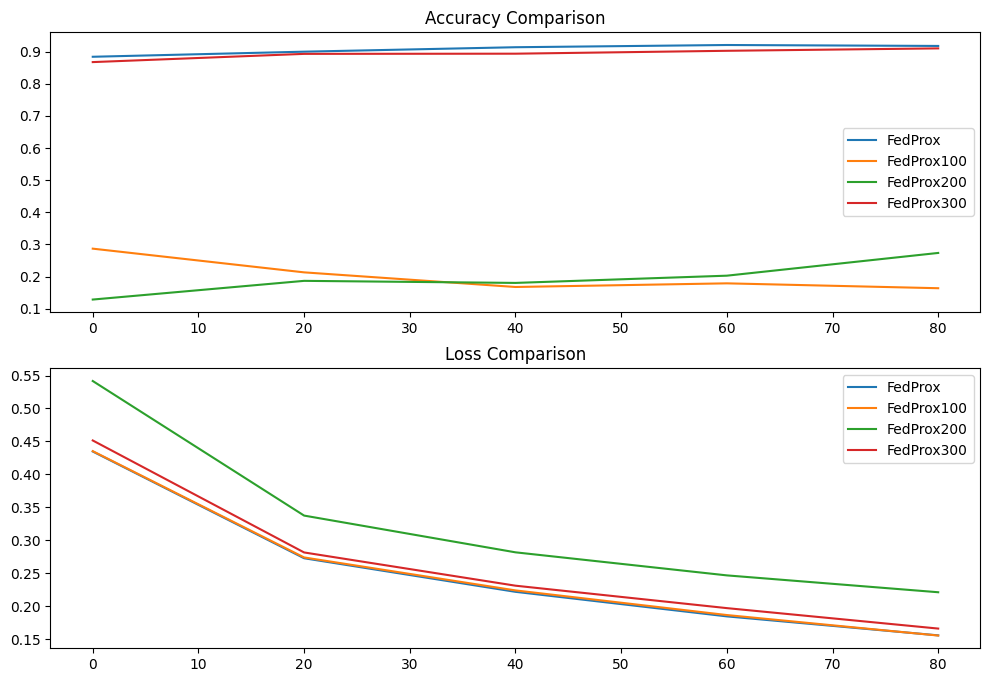

In [20]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance['accuracy'], label='FedProx')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance100['accuracy'], label='FedProx100')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance200['accuracy'], label='FedProx200')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance300['accuracy'], label='FedProx300')

# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance['loss'], label='FedProx')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance100['loss'], label='FedProx100')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance200['loss'], label='FedProx200')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance300['loss'], label='FedProx300')

plt.show()

In [19]:
# Train & Evaluate FedShare
fedshare_model = CNNModel().to(device)
fedshare_performance = train_federated_learning(fedshare_model, train_loaders[0], 'FedShare')
fedshare_model100 = CNNModel().to(device)
fedshare_performance100 = train_federated_learningAdj(fedshare_model100, train_loaders[0], 'FedShare100', 100)
fedshare_model200 = CNNModel().to(device)
fedshare_performance200 = train_federated_learningAdj(fedshare_model200, train_loaders[0], 'FedShare200', 200)
fedshare_model300 = CNNModel().to(device)
fedshare_performance300 = train_federated_learningAdj(fedshare_model300, train_loaders[0], 'FedShare300', 300)

Epoch 1/5 - FedShare:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/5 - FedShare: 100%|██████████| 750/750 [01:19<00:00,  9.38it/s]


Epoch [1/5] - FedShare, Loss: 0.4269
Epoch [1/5] - FedShare, Validation Accuracy: 89.12%


Epoch 2/5 - FedShare: 100%|██████████| 750/750 [02:09<00:00,  5.78it/s]


Epoch [2/5] - FedShare, Loss: 0.2646
Epoch [2/5] - FedShare, Validation Accuracy: 90.23%


Epoch 3/5 - FedShare: 100%|██████████| 750/750 [02:01<00:00,  6.20it/s]


Epoch [3/5] - FedShare, Loss: 0.2151
Epoch [3/5] - FedShare, Validation Accuracy: 91.03%


Epoch 4/5 - FedShare: 100%|██████████| 750/750 [02:14<00:00,  5.59it/s]


Epoch [4/5] - FedShare, Loss: 0.1768
Epoch [4/5] - FedShare, Validation Accuracy: 91.22%


Epoch 5/5 - FedShare: 100%|██████████| 750/750 [02:43<00:00,  4.59it/s]


Epoch [5/5] - FedShare, Loss: 0.1455
Epoch [5/5] - FedShare, Validation Accuracy: 92.06%


Epoch 1/5 - FedShare100: 100%|██████████| 750/750 [01:39<00:00,  7.50it/s]


Epoch [1/5] - FedShare100, Loss: 0.4626
Epoch [1/5] - FedShare100, Validation Accuracy: 84.19%


Epoch 2/5 - FedShare100: 100%|██████████| 750/750 [01:27<00:00,  8.56it/s]


Epoch [2/5] - FedShare100, Loss: 0.2859
Epoch [2/5] - FedShare100, Validation Accuracy: 87.47%


Epoch 3/5 - FedShare100: 100%|██████████| 750/750 [00:50<00:00, 14.85it/s]


Epoch [3/5] - FedShare100, Loss: 0.2382
Epoch [3/5] - FedShare100, Validation Accuracy: 85.15%


Epoch 4/5 - FedShare100: 100%|██████████| 750/750 [00:52<00:00, 14.25it/s]


Epoch [4/5] - FedShare100, Loss: 0.2033
Epoch [4/5] - FedShare100, Validation Accuracy: 85.71%


Epoch 5/5 - FedShare100: 100%|██████████| 750/750 [00:56<00:00, 13.35it/s]


Epoch [5/5] - FedShare100, Loss: 0.1762
Epoch [5/5] - FedShare100, Validation Accuracy: 88.15%


Epoch 1/5 - FedShare200: 100%|██████████| 750/750 [00:52<00:00, 14.36it/s]


Epoch [1/5] - FedShare200, Loss: 0.4605
Epoch [1/5] - FedShare200, Validation Accuracy: 9.93%


Epoch 2/5 - FedShare200: 100%|██████████| 750/750 [00:49<00:00, 15.25it/s]


Epoch [2/5] - FedShare200, Loss: 0.2864
Epoch [2/5] - FedShare200, Validation Accuracy: 12.06%


Epoch 3/5 - FedShare200: 100%|██████████| 750/750 [01:04<00:00, 11.59it/s]


Epoch [3/5] - FedShare200, Loss: 0.2362
Epoch [3/5] - FedShare200, Validation Accuracy: 12.48%


Epoch 4/5 - FedShare200: 100%|██████████| 750/750 [02:36<00:00,  4.78it/s]


Epoch [4/5] - FedShare200, Loss: 0.2035
Epoch [4/5] - FedShare200, Validation Accuracy: 12.31%


Epoch 5/5 - FedShare200: 100%|██████████| 750/750 [02:43<00:00,  4.59it/s]


Epoch [5/5] - FedShare200, Loss: 0.1741
Epoch [5/5] - FedShare200, Validation Accuracy: 13.53%


Epoch 1/5 - FedShare300: 100%|██████████| 750/750 [01:18<00:00,  9.52it/s]


Epoch [1/5] - FedShare300, Loss: 0.4834
Epoch [1/5] - FedShare300, Validation Accuracy: 86.67%


Epoch 2/5 - FedShare300: 100%|██████████| 750/750 [01:04<00:00, 11.66it/s]


Epoch [2/5] - FedShare300, Loss: 0.3005
Epoch [2/5] - FedShare300, Validation Accuracy: 87.21%


Epoch 3/5 - FedShare300: 100%|██████████| 750/750 [00:51<00:00, 14.70it/s]


Epoch [3/5] - FedShare300, Loss: 0.2490
Epoch [3/5] - FedShare300, Validation Accuracy: 88.44%


Epoch 4/5 - FedShare300: 100%|██████████| 750/750 [00:52<00:00, 14.24it/s]


Epoch [4/5] - FedShare300, Loss: 0.2136
Epoch [4/5] - FedShare300, Validation Accuracy: 86.98%


Epoch 5/5 - FedShare300: 100%|██████████| 750/750 [01:31<00:00,  8.17it/s]


Epoch [5/5] - FedShare300, Loss: 0.1847
Epoch [5/5] - FedShare300, Validation Accuracy: 88.53%


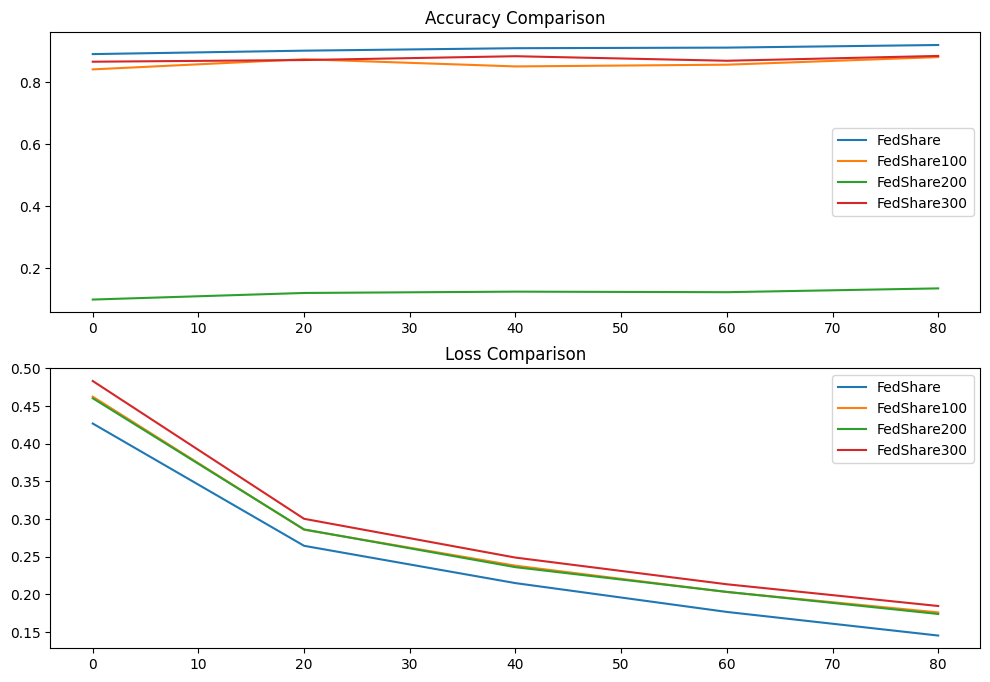

In [21]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance['accuracy'], label='FedShare')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance100['accuracy'], label='FedShare100')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance200['accuracy'], label='FedShare200')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance300['accuracy'], label='FedShare300')

# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance['loss'], label='FedShare')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance100['loss'], label='FedShare100')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance200['loss'], label='FedShare200')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance300['loss'], label='FedShare300')

plt.show()

In [26]:
# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_model = CNNModel().to(device)
fedmeta_uga_performance = train_federated_learning(fedmeta_uga_model, train_loaders[0], 'FedMeta w/ UGA')
# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_model100 = CNNModel().to(device)
fedmeta_uga_performance100 = train_federated_learningAdj(fedmeta_uga_model100, train_loaders[0], 'FedMeta w/ UGA100', 100)
# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_model200 = CNNModel().to(device)
fedmeta_uga_performance200 = train_federated_learningAdj(fedmeta_uga_model200, train_loaders[0], 'FedMeta w/ UGA200', 200)
# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_model300 = CNNModel().to(device)
fedmeta_uga_performance300 = train_federated_learningAdj(fedmeta_uga_model300, train_loaders[0], 'FedMeta w/ UGA300', 300)

Epoch 1/5 - FedMeta w/ UGA:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [01:09<00:00, 10.83it/s]


Epoch [1/5] - FedMeta w/ UGA, Loss: 0.4350
Epoch [1/5] - FedMeta w/ UGA, Validation Accuracy: 88.29%


Epoch 2/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [01:01<00:00, 12.21it/s]


Epoch [2/5] - FedMeta w/ UGA, Loss: 0.2694
Epoch [2/5] - FedMeta w/ UGA, Validation Accuracy: 90.38%


Epoch 3/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:50<00:00, 14.74it/s]


Epoch [3/5] - FedMeta w/ UGA, Loss: 0.2180
Epoch [3/5] - FedMeta w/ UGA, Validation Accuracy: 91.47%


Epoch 4/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:50<00:00, 14.85it/s]


Epoch [4/5] - FedMeta w/ UGA, Loss: 0.1845
Epoch [4/5] - FedMeta w/ UGA, Validation Accuracy: 91.51%


Epoch 5/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [01:50<00:00,  6.78it/s]


Epoch [5/5] - FedMeta w/ UGA, Loss: 0.1527
Epoch [5/5] - FedMeta w/ UGA, Validation Accuracy: 92.03%


Epoch 1/5 - FedMeta w/ UGA100: 100%|██████████| 750/750 [02:37<00:00,  4.76it/s]


Epoch [1/5] - FedMeta w/ UGA100, Loss: 0.4686
Epoch [1/5] - FedMeta w/ UGA100, Validation Accuracy: 66.22%


Epoch 2/5 - FedMeta w/ UGA100: 100%|██████████| 750/750 [00:52<00:00, 14.32it/s]


Epoch [2/5] - FedMeta w/ UGA100, Loss: 0.2986
Epoch [2/5] - FedMeta w/ UGA100, Validation Accuracy: 66.68%


Epoch 3/5 - FedMeta w/ UGA100: 100%|██████████| 750/750 [00:54<00:00, 13.67it/s]


Epoch [3/5] - FedMeta w/ UGA100, Loss: 0.2480
Epoch [3/5] - FedMeta w/ UGA100, Validation Accuracy: 60.29%


Epoch 4/5 - FedMeta w/ UGA100: 100%|██████████| 750/750 [00:50<00:00, 14.77it/s]


Epoch [4/5] - FedMeta w/ UGA100, Loss: 0.2173
Epoch [4/5] - FedMeta w/ UGA100, Validation Accuracy: 64.01%


Epoch 5/5 - FedMeta w/ UGA100: 100%|██████████| 750/750 [00:50<00:00, 14.79it/s]


Epoch [5/5] - FedMeta w/ UGA100, Loss: 0.1864
Epoch [5/5] - FedMeta w/ UGA100, Validation Accuracy: 69.71%


Epoch 1/5 - FedMeta w/ UGA200: 100%|██████████| 750/750 [00:52<00:00, 14.24it/s]


Epoch [1/5] - FedMeta w/ UGA200, Loss: 0.4298
Epoch [1/5] - FedMeta w/ UGA200, Validation Accuracy: 24.84%


Epoch 2/5 - FedMeta w/ UGA200: 100%|██████████| 750/750 [01:49<00:00,  6.84it/s]


Epoch [2/5] - FedMeta w/ UGA200, Loss: 0.2742
Epoch [2/5] - FedMeta w/ UGA200, Validation Accuracy: 19.43%


Epoch 3/5 - FedMeta w/ UGA200: 100%|██████████| 750/750 [02:58<00:00,  4.19it/s]


Epoch [3/5] - FedMeta w/ UGA200, Loss: 0.2248
Epoch [3/5] - FedMeta w/ UGA200, Validation Accuracy: 25.77%


Epoch 4/5 - FedMeta w/ UGA200: 100%|██████████| 750/750 [02:52<00:00,  4.34it/s]


Epoch [4/5] - FedMeta w/ UGA200, Loss: 0.1882
Epoch [4/5] - FedMeta w/ UGA200, Validation Accuracy: 24.62%


Epoch 5/5 - FedMeta w/ UGA200: 100%|██████████| 750/750 [02:49<00:00,  4.41it/s]


Epoch [5/5] - FedMeta w/ UGA200, Loss: 0.1576
Epoch [5/5] - FedMeta w/ UGA200, Validation Accuracy: 26.27%


Epoch 1/5 - FedMeta w/ UGA300: 100%|██████████| 750/750 [02:54<00:00,  4.31it/s]


Epoch [1/5] - FedMeta w/ UGA300, Loss: 0.4673
Epoch [1/5] - FedMeta w/ UGA300, Validation Accuracy: 20.32%


Epoch 2/5 - FedMeta w/ UGA300: 100%|██████████| 750/750 [01:56<00:00,  6.44it/s]


Epoch [2/5] - FedMeta w/ UGA300, Loss: 0.2905
Epoch [2/5] - FedMeta w/ UGA300, Validation Accuracy: 15.89%


Epoch 3/5 - FedMeta w/ UGA300: 100%|██████████| 750/750 [02:21<00:00,  5.31it/s]


Epoch [3/5] - FedMeta w/ UGA300, Loss: 0.2437
Epoch [3/5] - FedMeta w/ UGA300, Validation Accuracy: 14.55%


Epoch 4/5 - FedMeta w/ UGA300: 100%|██████████| 750/750 [02:40<00:00,  4.68it/s]


Epoch [4/5] - FedMeta w/ UGA300, Loss: 0.2066
Epoch [4/5] - FedMeta w/ UGA300, Validation Accuracy: 7.90%


Epoch 5/5 - FedMeta w/ UGA300: 100%|██████████| 750/750 [01:11<00:00, 10.55it/s]


Epoch [5/5] - FedMeta w/ UGA300, Loss: 0.1777
Epoch [5/5] - FedMeta w/ UGA300, Validation Accuracy: 10.70%


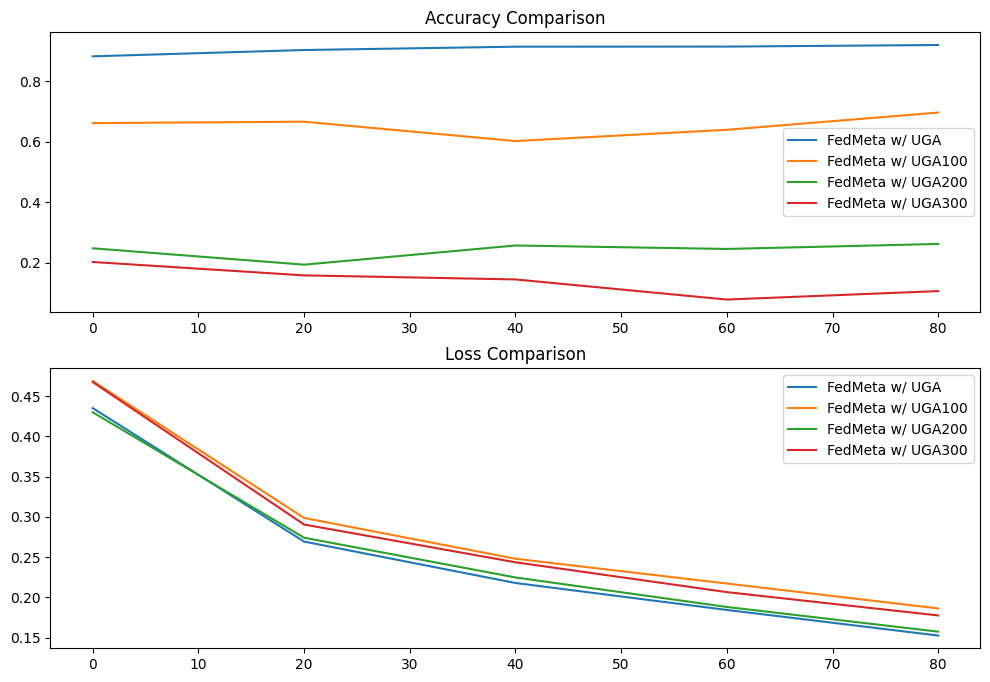

In [27]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance['accuracy'], label='FedMeta w/ UGA')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance100['accuracy'], label='FedMeta w/ UGA100')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance200['accuracy'], label='FedMeta w/ UGA200')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance300['accuracy'], label='FedMeta w/ UGA300')

# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance['loss'], label='FedMeta w/ UGA')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance100['loss'], label='FedMeta w/ UGA100')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance200['loss'], label='FedMeta w/ UGA200')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance300['loss'], label='FedMeta w/ UGA300')

plt.show()